#### 1. Packages
Import all the packages required.
1. __numpy__ - required for scientific computing with Python.
2. __h5py__ - to retrieve dataset stored in h5 file.
3. __matplotlib__ - to plot graphs in Python.
4. __copy__ - to use deepcopy - making a totally different object
5. __imageio__ - used to test with own picture at the end

In [129]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import copy
import imageio

#### 2. Loading the dataset of cat/non-cat picture
_Note This dataset is taken from [Kaggle][1] website_

[1]: https://www.kaggle.com/baners/a-logistic-regression-classifier-to-recognize-cats/data

1. Load the training dataset and extract the :
   * x_train - pixel values for each image for training the model
   * y_train - corresponding cat/non-cat value for training the model
2. Load the testing dataset and extract the :
   * x_test - pixel values for each image for testing the model
   * y_test - corresponding cat/non-cat value for testing the model's output
3. Extract the classes. (In our case "cat" and "non-cat")

In [130]:
def load_dataset():
    # load the training dataset
    train_dataset = h5py.File('dataset/train_catvnoncat.h5', "r")
    print("Structure of the train dataset : "+ str(train_dataset.keys()))
    x_train_original = np.array(train_dataset['train_set_x'])
    y_train_original = np.array(train_dataset['train_set_y'])
    
    # load the testing dataset
    test_dataset = h5py.File('dataset/test_catvnoncat.h5', "r")
    print("Structure of the test dataset : "+ str(test_dataset.keys()))
    x_test_original = np.array(test_dataset['test_set_x'])
    y_test_original = np.array(test_dataset['test_set_y'])

    # load the classification classes
    classes = np.array(test_dataset['list_classes'])

    return x_train_original, y_train_original, x_test_original, y_test_original, classes

#### 3. Preprocessing the data
1. Figure out the dimensions and the shape of the data 
   * m_train - number of training examples
   * m_test - number of testing examples
   * num_px - height and width of images (in our case height = width)
2. Flatten the image data of 3 RGB channels (numpx, numpx, numpx) into single vectors of shape (numpx * num_px * 3, 1)
3. Standardize (Normalize) the data

In [131]:
def preprocessing(x_train_original, y_train_original, x_test_original, y_test_original):

    # getting dimensions and shape of the data
    m_train = x_train_original.shape[0]
    m_test = x_test_original.shape[0]
    num_px = x_test_original.shape[1]

    # change the shape of the labels from (m,) to (1,m)
    y_train_preprocess = y_train_original.reshape(1, y_train_original.shape[0])
    y_test_preprocess = y_test_original.reshape(1, y_test_original.shape[0])

    print("\nNumber of testing examples = " + str(m_train))
    print("Number of testing examples = " + str(m_test))
    print("Height/Width of each image = " + str(num_px))

    print("\nOriginal training data shape: " + str(x_train_original.shape))
    print("Original testing data shape: " + str(x_test_original.shape))

    # flatten the data
    x_train_flatten = x_train_original.reshape(m_train, -1).T
    x_test_flatten = x_test_original.reshape(m_test, -1).T

    print("\nFlattened training data shape: " + str(x_train_flatten.shape))
    print("Flattened testing data shape: " + str(x_test_flatten.shape))

    # standardize the data
    x_train_standard = x_train_flatten / 255
    x_test_standard = x_test_flatten / 255

    return m_train, m_test, num_px, x_train_standard, y_train_preprocess, x_test_standard, y_test_preprocess

#### 4. Model Training
Model Training involves many steps
1. Initialize the weights and the bias to __zero__ value
2. Compute the sigmoid function. $sigmoid(z) = \frac{1}{1 + e^{-z}}$ for $z = w^T x + b$
    * for weights (w) and bias (b)
3. Forward Propagation of the network
   1. Get x_train
   2. Calculate Activation function: $A = \sigma(w^T X + b) = (a^{(1)}, a^{(2)}, ..., a^{(m-1)}, a^{(m)})$
   3. Calculate the Cost function: $J = -\frac{1}{m}\sum_{i=1}^{m}(y^{(i)}\log(a^{(i)})+(1-y^{(i)})\log(1-a^{(i)}))$
4. Backward Propagation of the network
   1. Find the gradients using the formulas:
   $$ \frac{\partial J}{\partial w} = \frac{1}{m}X(A-Y)^T\tag{7}$$
   $$ \frac{\partial J}{\partial b} = \frac{1}{m} \sum_{i=1}^m (a^{(i)}-y^{(i)})\tag{8}$$
5. Optimize the network using the __gradient descent__
   1. Learn the $w$ and $b$ by minimizing the cost function $J$
   2. Update rule for optimizing the parameters is $ \theta = \theta - \alpha \text{ } d\theta$, where $\alpha$ is the learning rate
6. Build a predictor for predicting outcomes
   1. Find the Activation for prediction data set (x_pred) using formula in step 3.2
   2. if Activation > 0.5 -> cat picture (y_pred = 1)
7. Create a Model using steps 1-6

In [132]:
# initialize the parameters to zero
def initialize_to_zero(dim):

    w = np.zeros((dim, 1))
    b = float(0)

    return w, b

In [133]:
# Compute the sigmoid
def sigmoid(z):

    s = 1 / (1 + np.exp(-z))

    return s

In [134]:
# Propagate through the network
def propagate(w, b, X, Y):

    # Find the number of examples in the given dataset X
    m = X.shape[1]
    # Forward Propagation of the network
    ## ------------------------------------------------------------------------ ##
    
    ## Calculate activation
    A = sigmoid(np.dot(w.T, X) + b)

    ## Calculate the cost 
    cost = (-1 / m) * np.sum((Y * np.log(A)) + ((1 - Y) * np.log(1 - A)))
    ## ------------------------------------------------------------------------ ##

    # Backward Propagation of the network
    ## ------------------------------------------------------------------------ ##

    dz = A - Y

    ## Calculate the gradients
    dw = (1 / m) * np.dot(X, dz.T)
    db = (1 / m) * np.sum(dz)
    ## ------------------------------------------------------------------------ ##

    # prepare the return variables
    cost = np.squeeze(np.array(cost))
    gradients = {"dw": dw, "db": db}

    return gradients, cost

In [135]:
# Optimize the network
def optimize(w, b, X, Y, num_iterations = 2000, learning_rate = 0.05, print_cost_requested = False):

    w = copy.deepcopy(w)
    b = copy.deepcopy(b)

    costs = []

    for i in range(num_iterations):
        gradients, cost = propagate(w, b, X, Y)

        dw = gradients["dw"]
        db = gradients["db"]

        # update the learning parameters
        w = w - learning_rate * dw
        b = b - learning_rate * db

        if print_cost_requested and i % 100 == 0:
            print("Cost after iteration %i = %f" %(i, cost))
            costs.append(cost)
    
    params = {"w": w, "b": b}

    return params, costs

In [136]:
# Build a predictor for predicting outcomes
def predict(w, b, x_prediction):
    
    m = x_prediction.shape[1]
    y_prediction = np.zeros((1, m))
    w = w.reshape(x_prediction.shape[0], 1)

    A = sigmoid(np.dot(w.T, x_prediction) + b)

    for i in range(A.shape[1]):
        if A[0, i] > 0.5:
            y_prediction[0, i] = 1
        else:
            y_prediction[0, i] = 0
    
    return y_prediction

In [137]:
# Create model using above functions
def model(x_train, y_train, x_test, y_test, num_iterations = 2000, learning_rate = 0.05, print_cost_requested = False):

    # initialize the parameters w and b
    w, b = initialize_to_zero(x_train.shape[0])

    # Traverse the pipeline and train the model
    # Forward Propagation - calculate the activation and cost
    # Backward Propagation - calculate the gradients
    # Optimization - optimize the cost using gradient descent
    print("\nModel Training")
    params, costs = optimize(w, b, x_train, y_train, num_iterations, learning_rate, print_cost_requested)
    print("Model Training completed")
    
    # Perform the Accuracy check and Testing using the Testing data 
    w = params["w"]
    b = params["b"]

    y_train_prediction = predict(w, b, x_train)
    print("\nTraining Accuracy = {} %".format(100 - np.mean(np.abs(y_train_prediction - y_train)) * 100))

    y_test_prediction = predict(w, b, x_test)
    print("Testing Accuracy = {} %".format(100 - np.mean(np.abs(y_test_prediction - y_test)) * 100))

    model_data = {
        "w": w,
        "b": b,
        "learning_rate": learning_rate,
        "num_iterations": num_iterations,
        "costs": costs,
        "y_train_prediction": y_train_prediction,
        "y_test_prediction": y_test_prediction
    }
    
    return model_data

#### Testing with own image
Here, the model is being tested with a custom image

In [138]:
def test_with_own_image(image):
    my_image = imageio.imread(image)
    image_array = np.resize(np.array(my_image),(num_px,num_px,3)).reshape((1, num_px*num_px*3)).T
    predicted_image = predict(logistic_regression_model["w"], logistic_regression_model["b"], image_array)

    plt.imshow(my_image)
    print("y = " + str(np.squeeze(predicted_image)) + ", algorithm predicts a \"" + 
        classes[int(np.squeeze(predicted_image)),].decode("utf-8") +  "\" picture.")

#### 6. Combining and making a whole pipeline
1. Load the Dataset
2. Preprocess the data
3. Train the model
4. Plot the learning curve
5. Testing with own image

Structure of the train dataset : <KeysViewHDF5 ['list_classes', 'train_set_x', 'train_set_y']>
Structure of the test dataset : <KeysViewHDF5 ['list_classes', 'test_set_x', 'test_set_y']>

Number of testing examples = 209
Number of testing examples = 50
Height/Width of each image = 64

Original training data shape: (209, 64, 64, 3)
Original testing data shape: (50, 64, 64, 3)

Flattened training data shape: (12288, 209)
Flattened testing data shape: (12288, 50)

Model Training
Cost after iteration 0 = 0.693147
Cost after iteration 100 = 0.584508
Cost after iteration 200 = 0.466949
Cost after iteration 300 = 0.376007
Cost after iteration 400 = 0.331463
Cost after iteration 500 = 0.303273
Cost after iteration 600 = 0.279880
Cost after iteration 700 = 0.260042
Cost after iteration 800 = 0.242941
Cost after iteration 900 = 0.228004
Cost after iteration 1000 = 0.214820
Cost after iteration 1100 = 0.203078
Cost after iteration 1200 = 0.192544
Cost after iteration 1300 = 0.183033
Cost after it

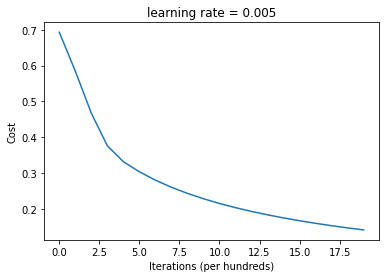

y = 1.0, algorithm predicts a "cat" picture.


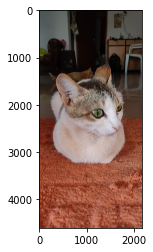

In [139]:
# Load the dataset
x_train_original, y_train_original, x_test_original, y_test_original, classes = load_dataset()

# preprocess the data
m_train, m_test, num_px, x_train_preprocess, y_train_preprocess, x_test_preprocess, y_test_preprocess = preprocessing(x_train_original, y_train_original, x_test_original, y_test_original)

# train the model
logistic_regression_model = model(x_train_preprocess, y_train_original, x_test_preprocess, y_test_original, num_iterations = 2000, learning_rate = 0.005, print_cost_requested = True)

# plot the learning curve
costs = np.squeeze(logistic_regression_model["costs"])
plt.plot(costs)
plt.ylabel("Cost")
plt.xlabel("Iterations (per hundreds)")
plt.title("learning rate = " + str(logistic_regression_model["learning_rate"]))
plt.show()

test_with_own_image("dataset/test_cat.jpg")